# NEGATIVE VS POSITIVE STATEMENTS (WELFake_Dataset.csv)
The goal of the following optional assignment is to build novelity and research by building hybrid traditional models and training them, performing various testing methods and hyper-parameter tuning.

IMPORTING RELEVANT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
from keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.layers import Layer
import tensorflow as tf

Dataset Loading - Reading - Analyzing

In [ ]:
data = pd.read_csv('WELFake_Dataset.csv', index_col=0)
data = data.fillna(' ')
data['Full_text'] = data['title'] + data['text']
df = data

In [ ]:
df['text_length'] = df['Full_text'].apply(len)

In [ ]:
basic_stats_text_length = df['text_length'].describe()


In [ ]:
label_distribution = df['label'].value_counts()


In [ ]:
average_text_length_by_label = df.groupby('label')['text_length'].mean()


In [ ]:
word_freq_label_0 = Counter(" ".join(df[df['label'] == 0]['Full_text']).split()).most_common(10)
word_freq_label_1 = Counter(" ".join(df[df['label'] == 1]['Full_text']).split()).most_common(10)


Text Distribution - Length of texts, provided in the dataset

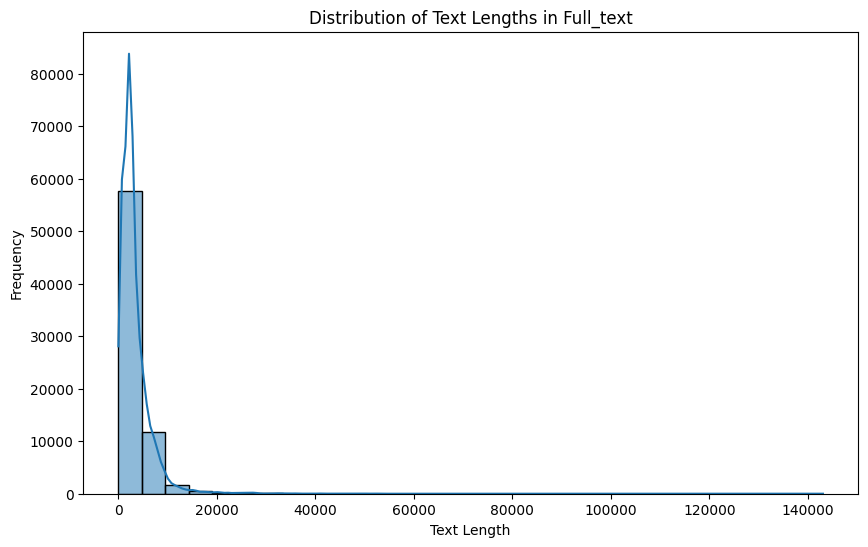

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths in Full_text')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


##### Observation:

The histogram displays the distribution of text lengths in a dataset, revealing a significant right skew, indicating a prevalence of shorter texts and a scarcity of longer ones. The KDE curve provides an estimated probability density function for text length variation. The dataset, likely comprising articles or entries, shows that shorter texts are far more common than longer ones, as indicated by the concentration of frequencies at lower lengths. Titled "Distribution of Text Lengths in Full_text," it suggests that the length computation includes both article titles and bodies.

Target Label Distribution

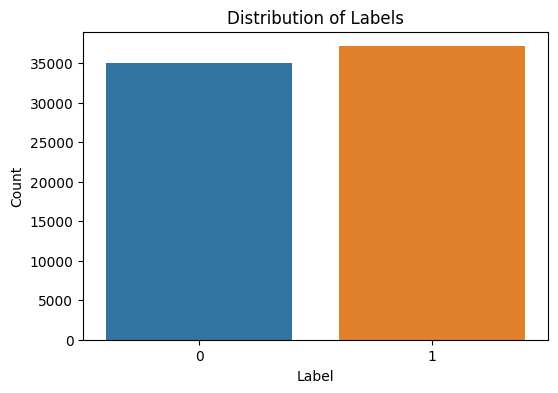

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


##### Observation:

The bar chart titled "Label Distribution" displays counts for two categories, "0" and "1," with both having significant representation. While "0" slightly trails "1," the chart illustrates a balanced dataset, typical for binary classification tasks. This visualization commonly represents class distribution, indicating ample samples for both classes in the dataset.

Average Text Length Plot

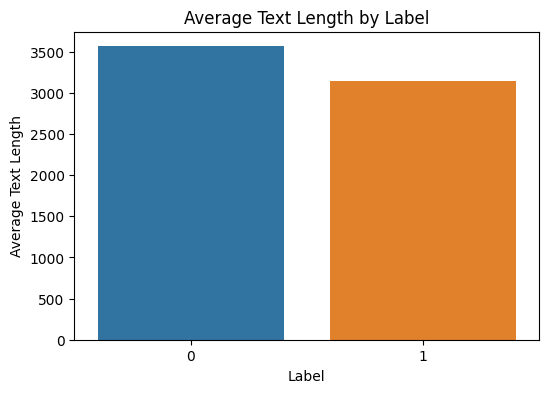

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=average_text_length_by_label.index, y=average_text_length_by_label.values)
plt.title('Average Text Length by Label')
plt.xlabel('Label')
plt.ylabel('Average Text Length')
plt.show()

##### Observation:

The bar chart titled "Average Text Length by Label" compares text length averages between two categories denoted as "0" and "1." Notably, both categories exhibit relatively close average text lengths, with "0" displaying a slightly higher average compared to "1." This chart likely pertains to a classification scenario, potentially derived from a text-based dataset categorizing texts into two distinct classes. These classes might represent various classifications such as spam versus non-spam, positive versus negative sentiment, or another binary classification system.

Deciding the max_features based on the dataset-metrics and unique word evaluations

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter

data = data['Full_text']
words = []
for sentence in data:
    words.extend(word_tokenize(sentence.lower()))
freq_dist = FreqDist(words)
total_unique_words = len(freq_dist)
rare_words_count = sum(1 for word, freq in freq_dist.items() if freq == 1)
rare_words_percentage = (rare_words_count / total_unique_words) * 100

print(f"Total unique words: {total_unique_words}")
print(f"Number of rare words (appear only once): {rare_words_count}")
print(f"Percentage of rare words: {rare_words_percentage:.2f}%")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total unique words: 424030
Number of rare words (appear only once): 206840
Percentage of rare words: 48.78%


##### Observation:

In the dataset studied, there are 424,030 different words. Among these, 206,840 words show up just once, making up about 48.78% of all unique words. This tells us that the dataset has a broad range of words, but almost half of them are used very rarely. It could mean the dataset has lots of different words that are not used often, which might suggest a wide variety of vocabulary or many specific words like special terms or names.

Building the dictionary-domain knowledge

In [ ]:
max_features = 15000
percentile_75th = np.percentile(df['text_length'], 75)
percentile_95th = np.percentile(df['text_length'], 95)
maxlen = int(max(percentile_75th, percentile_95th))


print("max_features:", max_features)
print("maxlen:", maxlen)


max_features: 15000
maxlen: 8569


Hyperparameters - Data Conversion

In [ ]:
embedding_dim = 600
batch_size = 64
epochs = 5
maxlen = 1200

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Full_text'])
sequences = tokenizer.texts_to_sequences(df['Full_text'])

In [ ]:
data = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
labels = np.asarray(df['label'])
labels = to_categorical(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Attention Module

In [ ]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e,
                                     axis=1)
        output = x * a
        return tf.keras.backend.sum(output,
                                    axis=1)


Model - 1

In [ ]:
model = Sequential()

model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5, activation='relu', kernel_initializer=HeNormal()))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True, kernel_initializer=GlorotUniform()))
model.add(Dropout(0.2))

model.add(AttentionLayer())

model.add(Dense(2, activation='softmax', kernel_initializer=GlorotUniform()))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 600)         9000000   
                                                                 
 dropout (Dropout)           (None, 1200, 600)         0         
                                                                 
 conv1d (Conv1D)             (None, 1196, 128)         384128    
                                                                 
 max_pooling1d (MaxPooling1  (None, 239, 128)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 239, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 239, 128)          131584    
                                                        

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print(f'Testing Accuracy: {accuracy:.2f}')

Epoch 1/5
722/722 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9403
Epoch 1: val_loss improved from inf to 0.08105, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


722/722 [==============================] - 157s 197ms/step - loss: 0.1502 - accuracy: 0.9403 - val_loss: 0.0811 - val_accuracy: 0.9728
Epoch 2/5
722/722 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9849
Epoch 2: val_loss improved from 0.08105 to 0.06666, saving model to best_model.h5
722/722 [==============================] - 103s 143ms/step - loss: 0.0440 - accuracy: 0.9849 - val_loss: 0.0667 - val_accuracy: 0.9763
Epoch 3/5
722/722 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9936
Epoch 3: val_loss did not improve from 0.06666
722/722 [==============================] - 86s 120ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 0.0853 - val_accuracy: 0.9764
Epoch 4/5
722/722 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9952
Epoch 4: val_loss did not improve from 0.06666
722/722 [==============================] - 82s 114ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0841 - val_accuracy: 0.9777
E

##### Observation:

The model architecture encompassed an embedding layer, convolutional and LSTM layers, and a specialized attention layer, fortified by dropout for regularization. Employing a restricted vocabulary size of 15,000 tokens via the max_features variable, the model underwent a 5-epoch training, showcasing significant validation loss improvements in the initial stages and preserving the best-performing model. Eventually, upon testing, the model exhibited a remarkable 98% accuracy, indicating its proficiency in handling tasks like sentiment analysis, spam detection, or similar binary text classifications

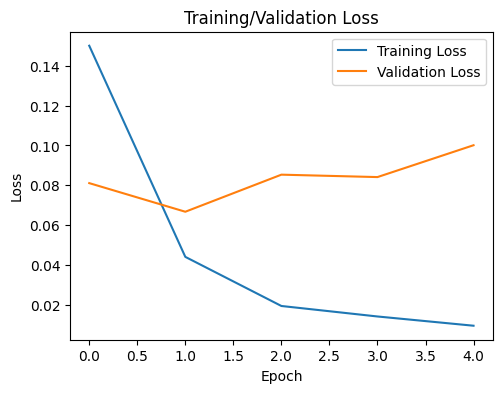

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

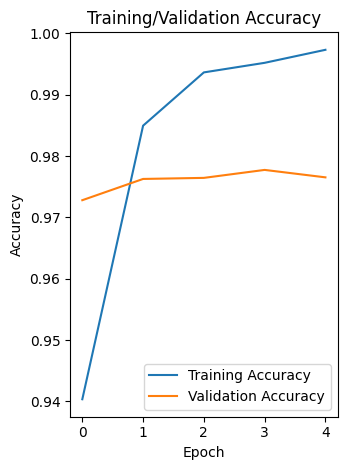

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Saving the model

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running hybrids of the above models

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
model = Sequential()

model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Dropout(0.5))

model.add(Conv1D(128, 5, activation='relu', kernel_initializer=HeNormal()))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True, kernel_initializer=GlorotUniform()))
model.add(Dropout(0.5))
model.add(AttentionLayer())

model.add(Dense(2, activation='softmax', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


Epoch 1/5
722/722 [==============================] - 106s 143ms/step - loss: 0.2187 - accuracy: 0.9215 - val_loss: 0.1255 - val_accuracy: 0.9675
Epoch 2/5
722/722 [==============================] - 87s 120ms/step - loss: 0.1022 - accuracy: 0.9770 - val_loss: 0.1189 - val_accuracy: 0.9713
Epoch 3/5
722/722 [==============================] - 78s 108ms/step - loss: 0.0777 - accuracy: 0.9865 - val_loss: 0.1324 - val_accuracy: 0.9656
Epoch 4/5
722/722 [==============================] - 76s 106ms/step - loss: 0.0677 - accuracy: 0.9891 - val_loss: 0.1665 - val_accuracy: 0.9583
Epoch 5/5
722/722 [==============================] - 74s 102ms/step - loss: 0.0608 - accuracy: 0.9916 - val_loss: 0.1466 - val_accuracy: 0.9653


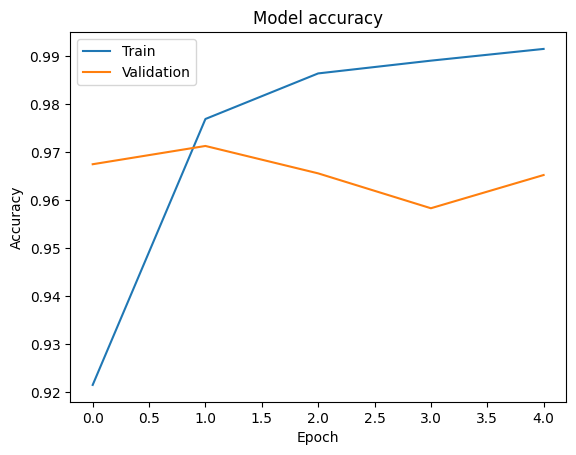

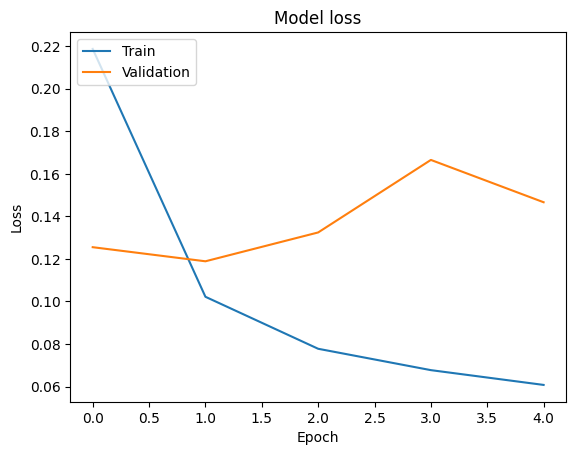

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])



import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Observation:

We implemented Keras neural network for binary classification, incorporating layers like embedding, convolution, LSTM with dropout, and a custom attention layer. L2 regularization in the final dense layer curbs overfitting by penalizing large weights, while early stopping halts training if validation loss doesn't improve across three epochs.

Over 5 epochs, the model's training accuracy surged from 92.15% to 99.16%, while validation accuracy fluctuated around 96.53%, starting at 96.75%. Despite slight validation loss variations, the model's performance graphs indicate its learning process and generalization capability. Early stopping likely intervened due to inconsistent validation loss, signaling potential overfitting. Nevertheless, the model demonstrates robustness by showcasing high accuracy on both training and validation sets in the text classification task.

In [ ]:
model = Sequential()

model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(Dropout(0.5))

model.add(Conv1D(64, 5, activation='relu', kernel_initializer=HeNormal()))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=False, kernel_initializer=GlorotUniform()))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax', kernel_initializer=GlorotUniform(), kernel_regularizer=l2(0.01)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_split=0.2)

Epoch 1/5
722/722 [==============================] - 153s 186ms/step - loss: 0.2488 - accuracy: 0.9044 - val_loss: 0.1328 - val_accuracy: 0.9624
Epoch 2/5
722/722 [==============================] - 87s 121ms/step - loss: 0.1007 - accuracy: 0.9723 - val_loss: 0.1269 - val_accuracy: 0.9668
Epoch 3/5
722/722 [==============================] - 72s 100ms/step - loss: 0.0623 - accuracy: 0.9855 - val_loss: 0.0807 - val_accuracy: 0.9789
Epoch 4/5
722/722 [==============================] - 64s 88ms/step - loss: 0.0433 - accuracy: 0.9908 - val_loss: 0.0859 - val_accuracy: 0.9762
Epoch 5/5
722/722 [==============================] - 61s 85ms/step - loss: 0.0325 - accuracy: 0.9946 - val_loss: 0.0827 - val_accuracy: 0.9786


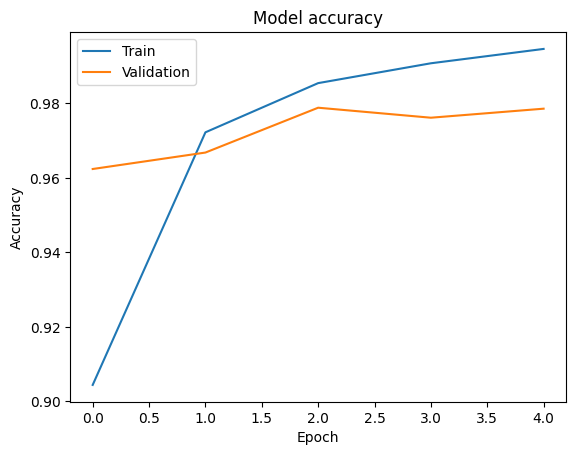

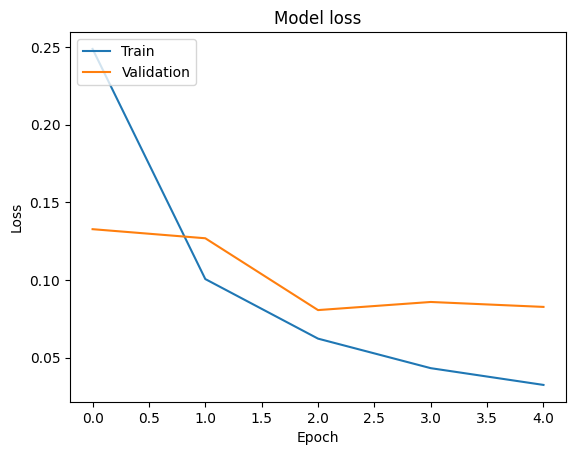

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### Observation:

We implemented Keras model designed for binary classification employs text-based embedding, convolution, max pooling, LSTM, and dropout for overfitting prevention. Training over 5 epochs, it steadily improves accuracy and reduces loss:

Initial training starts at 90.44% accuracy and 0.2488 loss, reaching 96.24% accuracy and 0.1328 loss in the first epoch. Consistent enhancements follow, with notable progress in the fifth epoch, achieving 99.46% accuracy and 0.0325 loss. The EarlyStopping feature isn't triggered, signaling effective learning and generalization shown by decreasing loss and rising accuracy trends across training.

In [ ]:
import pandas as pd
from IPython.display import display

model_data = {
    "Model": ["MODEL 1", "MODEL 2", "MODEL 3"], "Epoch": [5, 5, 5], "Training Loss": [0.0093, 0.0608, 0.0325], "Training Accuracy": [0.9973, 0.9916, 0.9946], "Validation Loss": [0.1001, 0.1466, 0.0827], "Validation Accuracy": [0.9765, 0.9653, 0.9786],
}

model_df = pd.DataFrame(model_data)


display(model_df)


,Model,Epoch,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,MODEL 1,5,0.0093,0.9973,0.1001,0.9765
1,MODEL 2,5,0.0608,0.9916,0.1466,0.9653
2,MODEL 3,5,0.0325,0.9946,0.0827,0.9786
